# GALSEN AI Fraud Detection Competition

### Importation des bibliothèques

In [ ]:
# Bibliothèque pour analyse des données
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Bibliothèque pour le model
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier

In [238]:
print(f"Version de pandas: {pd.__version__}")
print(f"Version de numpy: {np.__version__}")
print(f"Version de seaborn: {sns.__version__}")

Version de pandas: 2.2.2
Version de numpy: 1.26.4
Version de seaborn: 0.13.2


### Description des données

In [239]:
data_des = pd.read_csv('data/Xente_Variable_Definitions.csv')

print(data_des.to_markdown())

|    | Column Name          | Definition                                                                                                        |
|---:|:---------------------|:------------------------------------------------------------------------------------------------------------------|
|  0 | TransactionId        | Unique �transaction identifier on platform                                                                        |
|  1 | BatchId              | Unique number assigned to a batch of transactions for processing                                                  |
|  2 | AccountId            | Unique number identifying the customer on platform                                                                |
|  3 | SubscriptionId       | Unique number identifying the customer subscription                                                               |
|  4 | CustomerId           | Unique identifier attached to Account                                                         

### Chargement des données

In [240]:
TRAIN_PATH = 'data/training.csv'
TEST_PATH = 'data/test.csv'

train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

Test_TransactionId = test_data['TransactionId']

train_data

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0


In [241]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [242]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 45018
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         45019 non-null  object 
 1   BatchId               45019 non-null  object 
 2   AccountId             45019 non-null  object 
 3   SubscriptionId        45019 non-null  object 
 4   CustomerId            45019 non-null  object 
 5   CurrencyCode          45019 non-null  object 
 6   CountryCode           45019 non-null  int64  
 7   ProviderId            45019 non-null  object 
 8   ProductId             45019 non-null  object 
 9   ProductCategory       45019 non-null  object 
 10  ChannelId             45019 non-null  object 
 11  Amount                45019 non-null  float64
 12  Value                 45019 non-null  int64  
 13  TransactionStartTime  45019 non-null  object 
 14  PricingStrategy       45019 non-null  int64  
dtypes: float64(1), int6

### Identification des variables discrètes et continues

 - Variables continues: **Amount** et **Value**

 - Variables discrètes: Le reste des colonnes

### Analyse Exploratoire des données

|   FraudResult |   count |
|--------------:|--------:|
|             0 |   95469 |
|             1 |     193 |


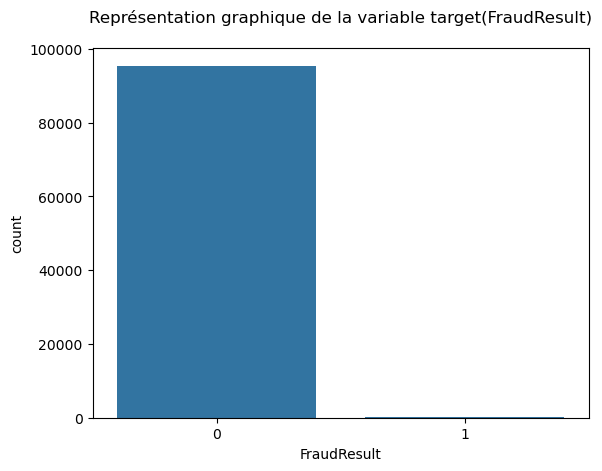

In [243]:
sns.countplot(train_data, x='FraudResult')
plt.title("Représentation graphique de la variable target(FraudResult)\n")

print(train_data['FraudResult'].value_counts(normalize=False).to_markdown())

Nous constatons un déséquilibre de notre variable target. Nous avons plus d'exemple de cas de non fraude que de cas de fraude dans notre dataset.

 - **Prportion fraude**: *0.00201752*

 - **Proportion non fraude**: *0.997982*

#### Analyse des variables continues

In [244]:
train_data['Value'].describe()

count    9.566200e+04
mean     9.900584e+03
std      1.231221e+05
min      2.000000e+00
25%      2.750000e+02
50%      1.000000e+03
75%      5.000000e+03
max      9.880000e+06
Name: Value, dtype: float64

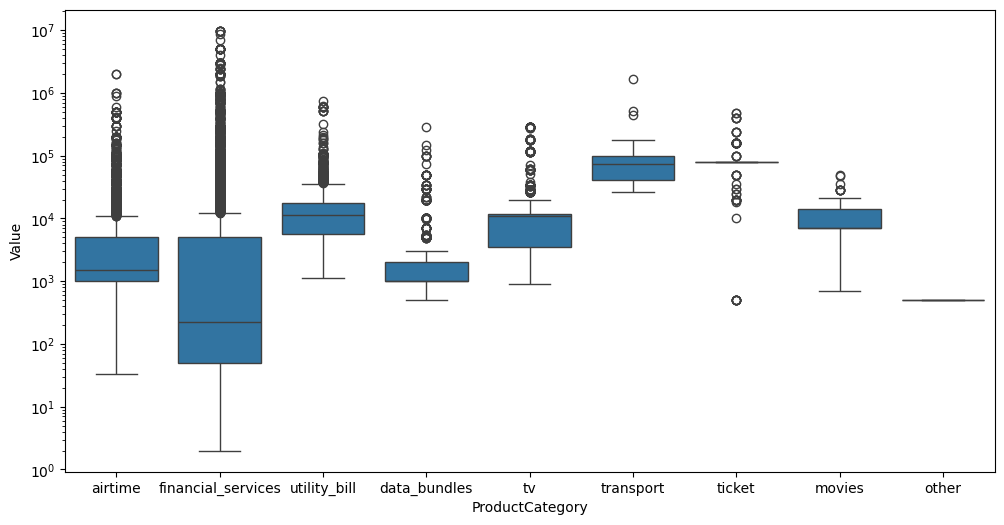

In [245]:
plt.figure(figsize=(12, 6))
sns.boxplot(train_data, y='Value', x='ProductCategory')
plt.yscale('log')

#### Analyse des variables discrètes

In [246]:
# train_data['AccountId'].unique().shape = 3633
# train_data['SubscriptionId'].unique().shape = 3627
# train_data['CustomerId'].unique().shape = 3742
# train_data['ProviderId'].unique().shape = 6
# train_data['ProductId'].unique().shape = 23

In [247]:
def show_feature_details(df: pd.DataFrame, feature: str, target: str):
    """
    Cette fonction permet de compter et d'afficher les categories d'une variable discrète et leur relation avec la target.
    """

    feature_count = df[feature].value_counts().rename('Total')
    fraud_count = df.groupby([feature, target]).size().unstack(fill_value=0)
    result = fraud_count.join(feature_count)
    result = pd.crosstab(df[feature], df[target], margins=True, margins_name='Total')

    print(result.to_markdown())


##### ProductId

In [248]:
show_feature_details(train_data, 'ProductId', 'FraudResult')

| ProductId    |     0 |   1 |   Total |
|:-------------|------:|----:|--------:|
| ProductId_1  |  2885 |   0 |    2885 |
| ProductId_10 | 15378 |   6 |   15384 |
| ProductId_11 |  1377 |   0 |    1377 |
| ProductId_12 |     2 |   0 |       2 |
| ProductId_13 |   290 |   6 |     296 |
| ProductId_14 |   789 |   0 |     789 |
| ProductId_15 | 11807 | 157 |   11964 |
| ProductId_16 |    10 |   0 |      10 |
| ProductId_19 |   965 |   0 |     965 |
| ProductId_2  |   236 |   0 |     236 |
| ProductId_20 |   216 |   0 |     216 |
| ProductId_21 |  1508 |   4 |    1512 |
| ProductId_22 |   110 |   2 |     112 |
| ProductId_23 |     1 |   0 |       1 |
| ProductId_24 |   175 |   0 |     175 |
| ProductId_27 |    31 |   0 |      31 |
| ProductId_3  | 24332 |  12 |   24344 |
| ProductId_4  |  2403 |   0 |    2403 |
| ProductId_5  |    23 |   2 |      25 |
| ProductId_6  | 32634 |   1 |   32635 |
| ProductId_7  |    86 |   0 |      86 |
| ProductId_8  |   197 |   0 |     197 |
| ProductId_9  |

- Les produits: **ProductId_15**, **ProductId_3**, **ProductId_10**, **ProductId_13**, **ProductId_21**, **ProductId_9**, **ProductId_22**, **ProductId_5** et **ProductId_6** sont ceux liés à des cas de fraude avec respectivement *157*, *12*, *6*, *6*, *4*, *3*, *2*, *2* et *1* fraude(s).

- La plupart des cas de fraudes sont liés au **produits_15**.

##### ProductCategory

| ProductCategory    |     0 |   1 |   Total |
|:-------------------|------:|----:|--------:|
| airtime            | 45009 |  18 |   45027 |
| data_bundles       |  1613 |   0 |    1613 |
| financial_services | 45244 | 161 |   45405 |
| movies             |   175 |   0 |     175 |
| other              |     2 |   0 |       2 |
| ticket             |   216 |   0 |     216 |
| transport          |    23 |   2 |      25 |
| tv                 |  1279 |   0 |    1279 |
| utility_bill       |  1908 |  12 |    1920 |
| Total              | 95469 | 193 |   95662 |


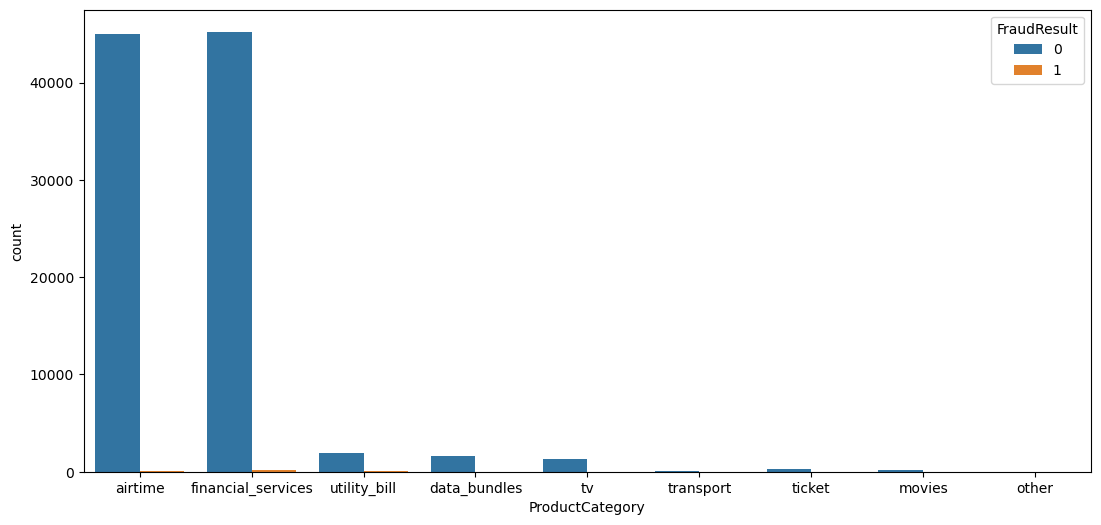

In [249]:
plt.figure(figsize=(13,6))
sns.countplot(train_data, x='ProductCategory', orient='y', hue='FraudResult')

show_feature_details(train_data, 'ProductCategory', 'FraudResult')

- Les cas de fraude sont enregistrés dans les catégories: *financial_services*, *airtime*, *utility_bill* et *transport*.

- La plupart des cas de fraude sont liés à la catégorie **financial_services** qvec **161 fraudes** enregistrées:

##### Relation entre ProductId et ProductCategory

<Axes: xlabel='ProductCategory', ylabel='ProductId'>

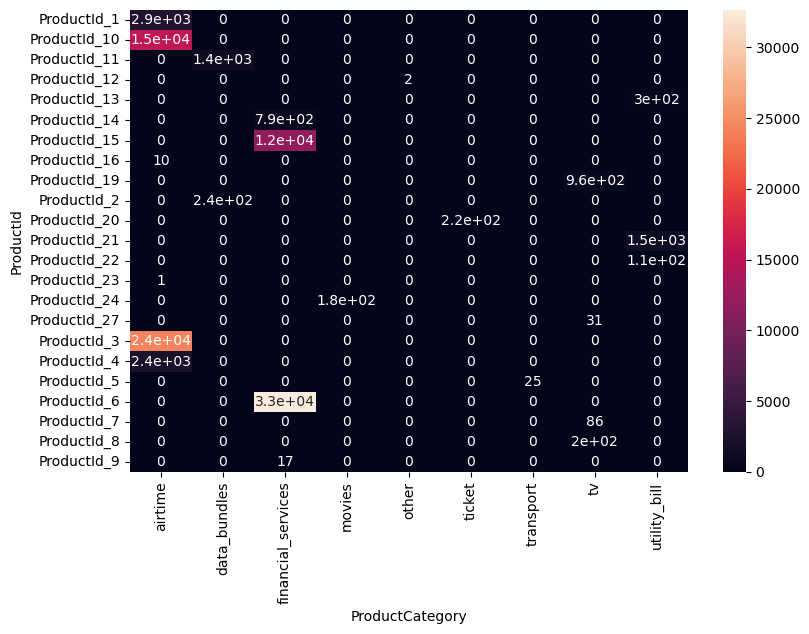

In [250]:
product_alalysis = pd.crosstab(train_data['ProductId'], train_data['ProductCategory'])
plt.figure(figsize=(9,6))
sns.heatmap(product_alalysis, annot=True)

##### ChanelId

In [251]:
show_feature_details(train_data, 'ChannelId', 'FraudResult')

| ChannelId   |     0 |   1 |   Total |
|:------------|------:|----:|--------:|
| ChannelId_1 |   534 |   4 |     538 |
| ChannelId_2 | 37136 |   5 |   37141 |
| ChannelId_3 | 56751 | 184 |   56935 |
| ChannelId_5 |  1048 |   0 |    1048 |
| Total       | 95469 | 193 |   95662 |


- Dans cette catégories seul les transactions faites sur le ***ChannelId_5*** ne présentent pas de fraude. La plupart des fraudes sont enregistrées dans le ***ChannelId_3***

##### PricingStrategy

In [252]:
show_feature_details(train_data, 'PricingStrategy', 'FraudResult')

| PricingStrategy   |     0 |   1 |   Total |
|:------------------|------:|----:|--------:|
| 0                 |   349 |  36 |     385 |
| 1                 |  1860 |   7 |    1867 |
| 2                 | 79709 | 139 |   79848 |
| 4                 | 13551 |  11 |   13562 |
| Total             | 95469 | 193 |   95662 |


##### Relation entre PricingStrategy et ProductCategory

<Axes: xlabel='PricingStrategy', ylabel='ProductCategory'>

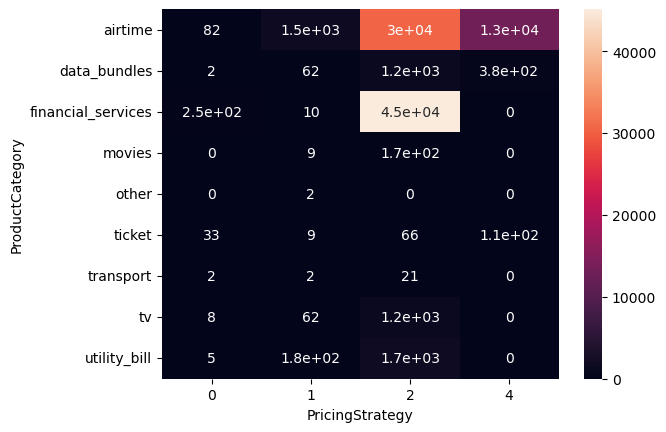

In [253]:
sns.heatmap(pd.crosstab(train_data['ProductCategory'], train_data['PricingStrategy']), annot=True)

##### ProviderId

In [254]:
# train_data['ProviderId'].value_counts()
show_feature_details(train_data, 'ProviderId', 'FraudResult')

| ProviderId   |     0 |   1 |   Total |
|:-------------|------:|----:|--------:|
| ProviderId_1 |  5586 |  57 |    5643 |
| ProviderId_2 |    18 |   0 |      18 |
| ProviderId_3 |  3020 |  64 |    3084 |
| ProviderId_4 | 38184 |   5 |   38189 |
| ProviderId_5 | 14478 |  64 |   14542 |
| ProviderId_6 | 34183 |   3 |   34186 |
| Total        | 95469 | 193 |   95662 |


In [255]:
train_data.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

### Features Engineering

##### Transformstion de la variable Amount

In [256]:
train_data['Amount_type'] = train_data['Amount'].apply(lambda val: 0 if val < 0 else 1)
test_data['Amount_type'] = test_data['Amount'].apply(lambda val: 0 if val < 0 else 1)

##### Extraction des dates

In [257]:
def extract_datetime_features(df: pd.DataFrame, datetime_col: str):

    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    datetime_features = {
        # f'{datetime_col}_dow': df[datetime_col].dt.day_name(),
        f'{datetime_col}_doy': df[datetime_col].dt.dayofyear,
        f'{datetime_col}_dom': df[datetime_col].dt.day,
        # f'{datetime_col}_hr': df[datetime_col].dt.hour,
        # f'{datetime_col}_min': df[datetime_col].dt.minute,
        f'{datetime_col}_is_wkd': df[datetime_col].dt.weekday >= 5,
        # f'{datetime_col}_yr': df[datetime_col].dt.year,
        # f'{datetime_col}_qtr': df[datetime_col].dt.quarter,
        # f'{datetime_col}_mth': df[datetime_col].dt.month
    }
    df.drop(columns=datetime_col, inplace=True)
    return datetime_features


In [258]:
date_train_features = extract_datetime_features(train_data, 'TransactionStartTime')
train_data = train_data.assign(**date_train_features)

date_test_features = extract_datetime_features(test_data, 'TransactionStartTime')
test_data = test_data.assign(**date_test_features)

**Colonnes à supprimer**:  'TransactionId', 'BatchId', 'CurrencyCode', 'CountryCode', 'Amount'

In [259]:
features_to_remove = ['TransactionId', 'BatchId', 'CurrencyCode', 'CountryCode', 'Amount']

X_train = train_data.drop(columns=features_to_remove)
X_test = test_data.drop(columns=features_to_remove)

X_train

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,FraudResult,Amount_type,TransactionStartTime_doy,TransactionStartTime_dom,TransactionStartTime_is_wkd
0,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,2,0,1,319,15,False
1,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,20,2,0,0,319,15,False
2,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500,2,0,1,319,15,False
3,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,21800,2,0,1,319,15,False
4,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,644,2,0,0,319,15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,AccountId_4841,SubscriptionId_3829,CustomerId_3078,ProviderId_4,ProductId_6,financial_services,ChannelId_2,1000,2,0,0,44,13,False
95658,AccountId_3439,SubscriptionId_2643,CustomerId_3874,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000,2,0,1,44,13,False
95659,AccountId_4841,SubscriptionId_3829,CustomerId_3874,ProviderId_4,ProductId_6,financial_services,ChannelId_2,20,2,0,0,44,13,False
95660,AccountId_1346,SubscriptionId_652,CustomerId_1709,ProviderId_6,ProductId_19,tv,ChannelId_3,3000,2,0,1,44,13,False


### Développement du Model

In [260]:
# show_feature_details(train_data, 'TransactionStartTime_hr', 'FraudResult')

colonnes à supprimer: 'TransactionStartTime_dow', 'TransactionStartTime_mth'

##### Encodage des classes catégoricielle

 - **1ere Approche**

In [261]:
# Colonnes à encoder
# features_to_encode_1 = ['AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

# high_cardinality_features = ['ProviderId', 'ProductId']

# low_cardinality_features = ['ProductCategory', 'ChannelId']


In [262]:
# def frequency_encoding(df, column):
#     freq = df[column].value_counts() / len(df)  # Calcul de la fréquence
#     return df[column].map(freq)


In [263]:
# for col in ['AccountId', 'SubscriptionId', 'CustomerId']:
#     X_train[col] = frequency_encoding(X_train, col)
#     X_test[col] = frequency_encoding(X_test, col)

In [264]:
# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# X_train[low_cardinality_features] = encoder.fit_transform(X_train[low_cardinality_features])
# X_test[low_cardinality_features] = encoder.transform(X_test[low_cardinality_features])

 - **2eme Approche**

In [265]:
y = train_data['FraudResult']
X_train.drop(columns=['FraudResult'], inplace=True)

In [266]:
features_to_encode_2 = ['ProductId', 'ProductCategory', 'AccountId', 'SubscriptionId', 'CustomerId']

dict_provider = {
    'ProviderId_1': 1,
    'ProviderId_2': 2,
    'ProviderId_3': 3,
    'ProviderId_4': 4,
    'ProviderId_5': 5,
    'ProviderId_6': 6,
}

X_train['ProviderId'] = X_train['ProviderId'].map(dict_provider)
X_test['ProviderId'] = X_test['ProviderId'].map(dict_provider)


dict_channel = {
    'ChannelId_1': 1,
    'ChannelId_2': 2,
    'ChannelId_3': 3,
    'ChannelId_4': 4,
    'ChannelId_5': 5,
}

X_train['ChannelId'] = X_train['ChannelId'].map(dict_channel)
X_test['ChannelId'] = X_test['ChannelId'].map(dict_channel)

In [267]:
from category_encoders.count import CountEncoder

enc = CountEncoder(cols = features_to_encode_2).fit(X_train)
X_train = enc.transform(X_train)
X_test = enc.transform(X_test)

In [268]:
# X_train = X_train.drop(columns=['AccountId', 'SubscriptionId', 'CustomerId'])
# X_test = X_test.drop(columns=['AccountId', 'SubscriptionId', 'CustomerId'])

rm_col = ['CustomerId']
X_train = X_train.drop(columns=rm_col)
X_test = X_test.drop(columns=rm_col)

X_train

,AccountId,SubscriptionId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,Amount_type,TransactionStartTime_doy,TransactionStartTime_dom,TransactionStartTime_is_wkd
0,66,66,6,15384,45027,3,1000,2,1,319,15,False
1,30893,32630,4,32635,45405,2,20,2,0,319,15,False
2,2,2,6,2885,45027,3,500,2,1,319,15,False
3,26,26,1,1512,1920,3,21800,2,1,319,15,False
4,30893,32630,4,32635,45405,2,644,2,0,319,15,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95657,30893,32630,4,32635,45405,2,1000,2,0,44,13,False
95658,27,27,6,15384,45027,3,1000,2,1,44,13,False
95659,30893,32630,4,32635,45405,2,20,2,0,44,13,False
95660,350,350,6,965,1279,3,3000,2,1,44,13,False


In [269]:
# y = train_data['FraudResult']
X = X_train
# .drop(columns=['FraudResult'])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=43)

##### Stardarisation de la colonne Value 

In [270]:
std_scaler = StandardScaler()

X_tr['Value'] = std_scaler.fit_transform(X_tr[['Value']])
X_te['Value'] = std_scaler.transform(X_te[['Value']])

X_test['Value'] = std_scaler.transform(X_test[['Value']])

In [271]:
X_tr

,AccountId,SubscriptionId,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,Amount_type,TransactionStartTime_doy,TransactionStartTime_dom,TransactionStartTime_is_wkd
53329,4457,4457,4,15384,45027,2,0.173760,4,0,8,8,False
60244,25,25,6,24344,45027,3,0.087835,2,1,14,14,False
88038,134,134,5,11964,45405,3,0.001909,2,1,38,7,False
35686,30893,32630,4,32635,45405,2,-0.083587,2,0,355,21,False
32729,29,29,5,2885,45027,3,-0.058239,4,1,353,19,False
...,...,...,...,...,...,...,...,...,...,...,...,...
57651,3,3,3,15384,45027,3,0.001909,1,1,11,11,False
83984,88,88,6,24344,45027,3,-0.075424,2,1,34,3,True
40753,31,31,6,15384,45027,3,-0.079720,2,1,360,26,False
19776,62,62,6,15384,45027,3,-0.075424,2,1,341,7,False


##### Courbe d'apprentissage

In [272]:
# Ploat learning curve
def plot_learning_curve(model, X, y):
    
    from sklearn.model_selection import learning_curve
    
    train_size, train_score, val_score = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='f1', n_jobs=-1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_size, train_score.mean(axis=1), label='train')
    plt.plot(train_size, val_score.mean(axis=1), label='validation')
    plt.xlabel('train_size')
    plt.ylabel('f1_score')
    plt.legend()
    plt.title('Learning curve')

##### BalancedRandomForestClassifier algorithme

/home/ahmad-guler/anaconda3/envs/titanic/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/ahmad-guler/anaconda3/envs/titanic/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


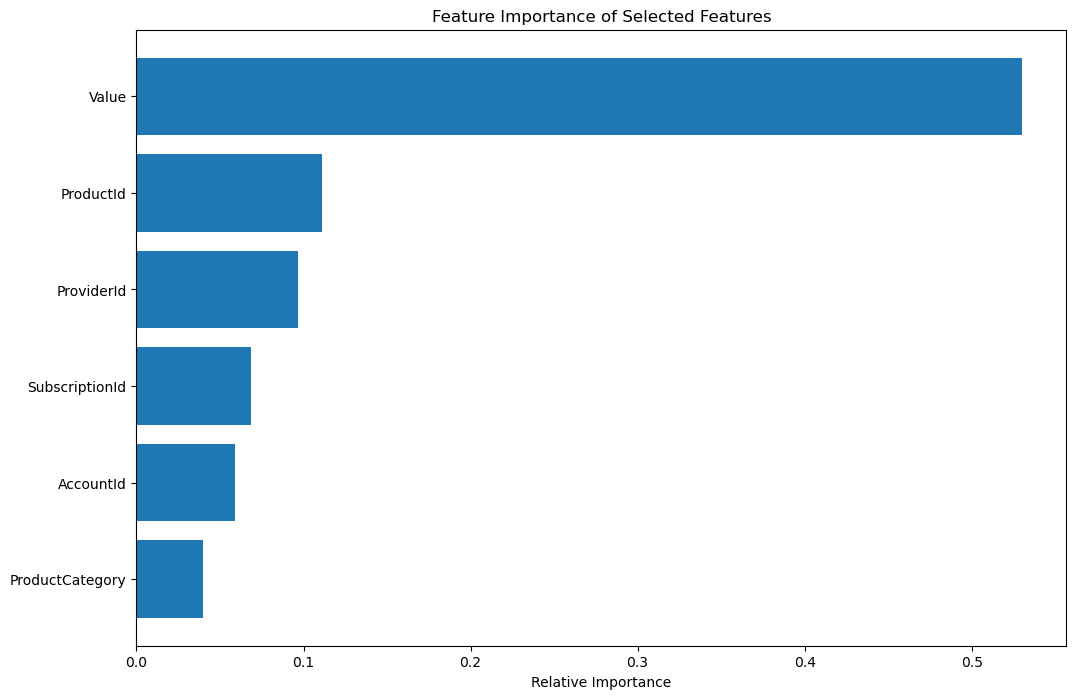

In [ ]:
from sklearn.feature_selection import SelectFromModel


selector = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
selector.fit(X_tr, y_tr)
model = SelectFromModel(selector, threshold='median', prefit=True)
selected_mask = model.get_support()
selected_columns = X_train.columns[selected_mask]

X_train_selected = model.transform(X_tr)
X_test_selected = model.transform(X_te)

# Visualize feature importance of the selected features
importances = selector.feature_importances_
selected_importances = importances[selected_mask]
indices = np.argsort(selected_importances)[::-1]
selected_names_sorted = [selected_columns[i] for i in indices]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance of Selected Features")
plt.barh(range(len(selected_importances)), selected_importances[indices])
plt.yticks(range(len(selected_importances)), selected_names_sorted)
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  
plt.show()


# brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
# selector.fit(X_tr, y_tr)

# y_pred = selector.predict(X_te)

# plot_learning_curve(selector, X_tr, y_tr)

# print(f"""
#     Accuracy: {accuracy_score(y_te, y_pred)}\n
#     Precision: {precision_score(y_te, y_pred)}\n
#     Recall: {recall_score(y_te, y_pred)}\n
#     F1_score: {f1_score(y_te, y_pred)}
# """)

##### DecisionTreeClassifier algorithme

In [274]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier(class_weight={0: 1, 1: 10}, random_state=42)

# param_grid = {
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [5, 10, 20],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['sqrt', 'log2'],
#     'criterion': ['gini', 'entropy'],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
# grid_search.fit(X_tr, y_tr)

# best_mod = grid_search.best_estimator_

# Train a cost-sensitive decision tree
# dtc.fit(X_tr, y_tr)

# # Evaluate the model
# y_pred = dtc.predict(X_te)

# plot_learning_curve(dtc, X_tr, y_tr)

# print(classification_report(y_te, y_pred))
# print(f"""
#     Accuracy: {accuracy_score(y_te, y_pred)}\n
#     Precision: {precision_score(y_te, y_pred)}\n
#     Recall: {recall_score(y_te, y_pred)}\n
#     F1_score: {f1_score(y_te, y_pred)}
# """)


##### Utilisation de smote pour équilibrer les classes

In [275]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print('SMOTE class distribution:', Counter(y_smote))


SMOTE class distribution: Counter({0: 95469, 1: 95469})


##### XGBClassifier algorithme

In [276]:
# from xgboost import XGBClassifier

# xgb = XGBClassifier(random_state=42)

# #Avec smote
# xgb.fit(X_smote, y_smote)
# y_pred_smot = xgb.predict(X_te)

# #Sans smote
# xgb.fit(X_tr, y_tr)
# y_pred_not_smot = xgb.predict(X_te)

# plot_learning_curve(xgb, X_tr, y_tr)

# # print(classification_report(y_te, y_pred))

# print(f"""
#     Accuracy: sans smote: {accuracy_score(y_te, y_pred_not_smot)}, avec smote: {accuracy_score(y_te, y_pred_smot)}\n
#     Precision: sans smote: {precision_score(y_te, y_pred_not_smot)}, avec smote: {precision_score(y_te, y_pred_smot)}\n
#     Recall: sans smote: {recall_score(y_te, y_pred_not_smot)}, avec smote: {recall_score(y_te, y_pred_smot)}\n
#     F1_score: sans smote: {f1_score(y_te, y_pred_not_smot)}, avec smote: {f1_score(y_te, y_pred_smot)}
# """)

##### RandomForestClassifier algorithme

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

# param_grid = {
#     'n_estimators': [200, 500, 1000],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [5, 10, 20],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced']
# }

# grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
# grid_search.fit(X_tr, y_tr)

# best_mod = grid_search.best_estimator_
#avec smote
# rfc.fit(X_smote, y_smote)
# y_pred_smot = rfc.predict(X_te)

#Sans smote
# rfc.fit(X_tr, y_tr)
# y_pred = rfc.predict(X_te)

# plot_learning_curve(rfc, X_tr, y_tr)
# print(classification_report(y_te, y_pred))

# print(f"""
#     Accuracy: sans smote: {accuracy_score(y_te, y_pred_not_smot)}, avec smote: {accuracy_score(y_te, y_pred_smot)}\n
#     Precision: sans smote: {precision_score(y_te, y_pred_not_smot)}, avec smote: {precision_score(y_te, y_pred_smot)}\n
#     Recall: sans smote: {recall_score(y_te, y_pred_not_smot)}, avec smote: {recall_score(y_te, y_pred_smot)}\n
#     F1_score: sans smote: {f1_score(y_te, y_pred_not_smot)}, avec smote: {f1_score(y_te, y_pred_smot)}
# """)

# print(f"""
#     Accuracy: {accuracy_score(y_te, y_pred)}\n
#     Precision: {precision_score(y_te, y_pred)}\n
#     Recall: {recall_score(y_te, y_pred)}\n
#     F1_score: {f1_score(y_te, y_pred)}
# """)

##### VotingClassifier

/home/ahmad-guler/anaconda3/envs/titanic/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ahmad-guler/anaconda3/envs/titanic/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19094
           1       0.90      0.90      0.90        39

    accuracy                           1.00     19133
   macro avg       0.95      0.95      0.95     19133
weighted avg       1.00      1.00      1.00     19133


    Accuracy: 0.9995818742486803

    Precision: 0.8974358974358975

    Recall: 0.8974358974358975

    F1_score: 0.8974358974358975



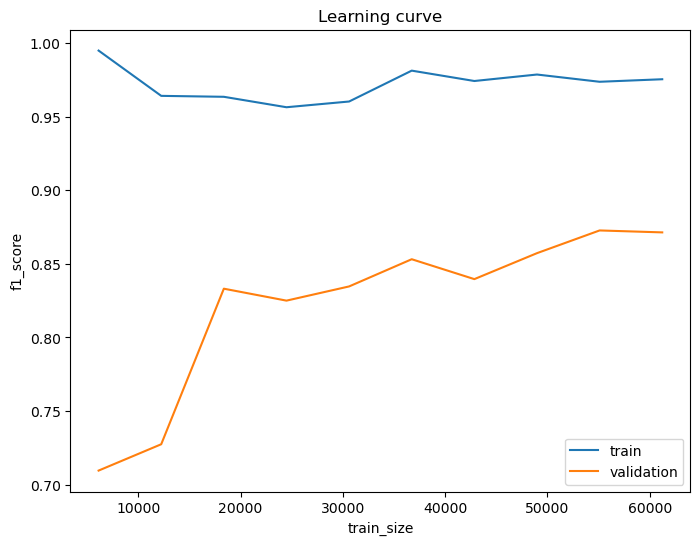

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


vc = VotingClassifier(estimators=[
    ('dtc', dtc),
    ('rfc', rfc),
    ('gnb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('lr', LogisticRegression(random_state=1))
], voting='soft')

vc.fit(X_tr[selected_names_sorted], y_tr)

y_pred = vc.predict(X_te[selected_names_sorted])

plot_learning_curve(vc, X_tr, y_tr)
print(classification_report(y_te, y_pred))

print(f"""
    Accuracy: {accuracy_score(y_te, y_pred)}\n
    Precision: {precision_score(y_te, y_pred)}\n
    Recall: {recall_score(y_te, y_pred)}\n
    F1_score: {f1_score(y_te, y_pred)}
""")



##### MultiLayerPerceptron Classifier

In [279]:
# from sklearn.neural_network import MLPClassifier

# mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(6, 3), random_state=1)

# mlpc.fit(X_tr, y_tr)

# y_pred = mlpc.predict(X_te)

# plot_learning_curve(mlpc, X_tr, y_tr)
# # print(classification_report(y_te, y_pred))

# print(f"""
#     Accuracy: {accuracy_score(y_te, y_pred)}\n
#     Precision: {precision_score(y_te, y_pred)}\n
#     Recall: {recall_score(y_te, y_pred)}\n
#     F1_score: {f1_score(y_te, y_pred)}
# """)

##### Nearest Neighbors Classification

In [280]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# knn.fit(X_tr, y_tr)

# y_pred = knn.predict(X_te)

# plot_learning_curve(knn, X_tr, y_tr)
# # print(classification_report(y_te, y_pred))

# print(f"""
#     Accuracy: {accuracy_score(y_te, y_pred)}\n
#     Precision: {precision_score(y_te, y_pred)}\n
#     Recall: {recall_score(y_te, y_pred)}\n
#     F1_score: {f1_score(y_te, y_pred)}
# """)

##### Choix du meilleur model

In [283]:
best_model = vc

y_sub = best_model.predict(X_test[selected_names_sorted])

sub = pd.DataFrame({
    'TransactionId': Test_TransactionId,
    'FraudResult': y_sub.astype(int)
})


sub.to_csv('submission.csv', index=False)